# Публичное решение соревнования WILDFIRE AI

В решении задачи классификации типов пожаров в соревновании предлагается использовать данные о точках пожаров и наборы открытых исторических данных.

В этом публичном решении я хочу показать, как можно набрать относительно приличный скор (> 0.91 по метрике Micro-averaged Multi-Class ROC-AUC на Public части данных) используя только данные о точках пожаров - `latitude`, `longitude` и `date`

In [1]:
import pickle
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import FeaturesData, CatBoostClassifier

%matplotlib inline

train = pd.read_csv('data/wildfires_train.csv')
check = pd.read_csv('data/wildfires_check.csv')
# Буду использовать для обучения данные и из train, и из check
data = pd.concat([train, check])

In [2]:
data.head()

,fire_id,date,latitude,longitude,fire_type,fire_type_name
0,0,2012-01-01,42.913439,133.887370,4,сжигание порубочных остатков
1,1,2012-01-01,43.378618,131.772265,3,горение мусора
2,2,2012-01-01,42.634134,130.479116,4,сжигание порубочных остатков
3,3,2012-01-02,43.108370,132.001058,11,не подтверждено
4,4,2012-01-02,42.890825,131.337416,4,сжигание порубочных остатков


In [3]:
print(data['date'].min())
print(data['date'].max())

2012-01-01
2019-05-01


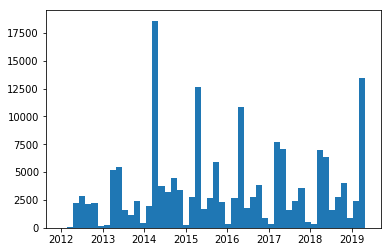

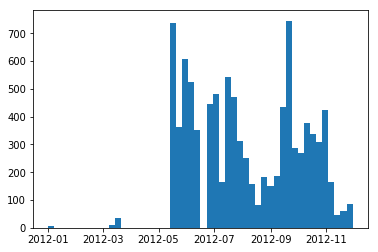

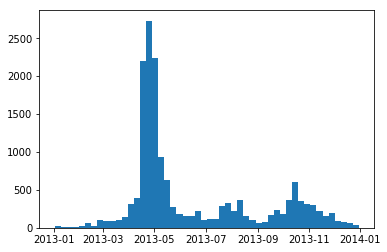

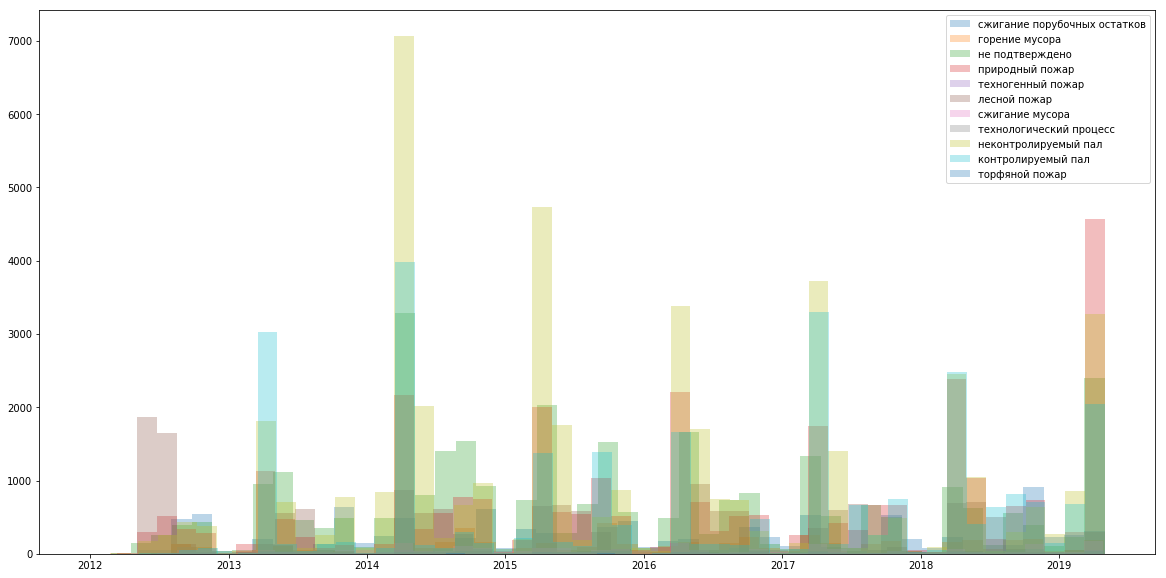

In [5]:
data['datetime'] = pd.to_datetime(data['date'])
data['year'] = data['datetime'].apply(lambda x: x.year)

fire_types = dict(data[['fire_type', 'fire_type_name']].drop_duplicates().values)

plt.hist(data['datetime'], bins = 50)
plt.show()

for year in [2012, 2013]:
    plt.hist(data[data['year'] == year]['datetime'], bins = 50)
    plt.show()
    
plt.figure(figsize = (20, 10))
for fire_type in fire_types.keys():
    plt.hist(data[data['fire_type'] == fire_type]['datetime'], alpha = 0.3, bins = 50, label = fire_types[fire_type])
plt.legend()
plt.show()

Как видно из гистограмм:
- пожары распределены очень неравномерно в течение года (что логично, зимой их похоже гораздо меньше)
- пожары распределены по-разному внутри каждого года
- разные типы пожаров тоже по-разному распределены по времени

Т.о. на основе `date` можно нагенерить много важных фичей для определения типа пожара.

Например таких:
- `year`, `month`, `day` 
- `day_from_start` - номер дня, если отсчитывать их от начала данных - 2012-01-01
- `day_of_year` - номер дня с начала года
- `day_of_year_sin`, `day_of_year_cos` - sin и cos от `day_of_year` - чтобы учитывать цикличность номеров дней в году

In [6]:
data['month'] = data['datetime'].apply(lambda x: x.month)
data['day']   = data['datetime'].apply(lambda x: x.day)


data['day_from_start']  = data['datetime'].apply(lambda x: (x.to_pydatetime().date() - date(2012, 1, 1)).days)
data['day_of_year']     = data['datetime'].apply(lambda x: (x.to_pydatetime().date() - date(x.year, 1, 1)).days)
data['day_of_year_cos'] = data['day_of_year'].apply(lambda x: np.cos(2 * np.pi * x / 365))
data['day_of_year_sin'] = data['day_of_year'].apply(lambda x: np.sin(2 * np.pi * x / 365))

In [7]:
data.head()

,fire_id,date,latitude,longitude,fire_type,fire_type_name,datetime,year,month,day,day_from_start,day_of_year,day_of_year_cos,day_of_year_sin
0,0,2012-01-01,42.913439,133.887370,4,сжигание порубочных остатков,2012-01-01,2012,1,1,0,0,1.000000,0.000000
1,1,2012-01-01,43.378618,131.772265,3,горение мусора,2012-01-01,2012,1,1,0,0,1.000000,0.000000
2,2,2012-01-01,42.634134,130.479116,4,сжигание порубочных остатков,2012-01-01,2012,1,1,0,0,1.000000,0.000000
3,3,2012-01-02,43.108370,132.001058,11,не подтверждено,2012-01-02,2012,1,2,1,1,0.999852,0.017213
4,4,2012-01-02,42.890825,131.337416,4,сжигание порубочных остатков,2012-01-02,2012,1,2,1,1,0.999852,0.017213


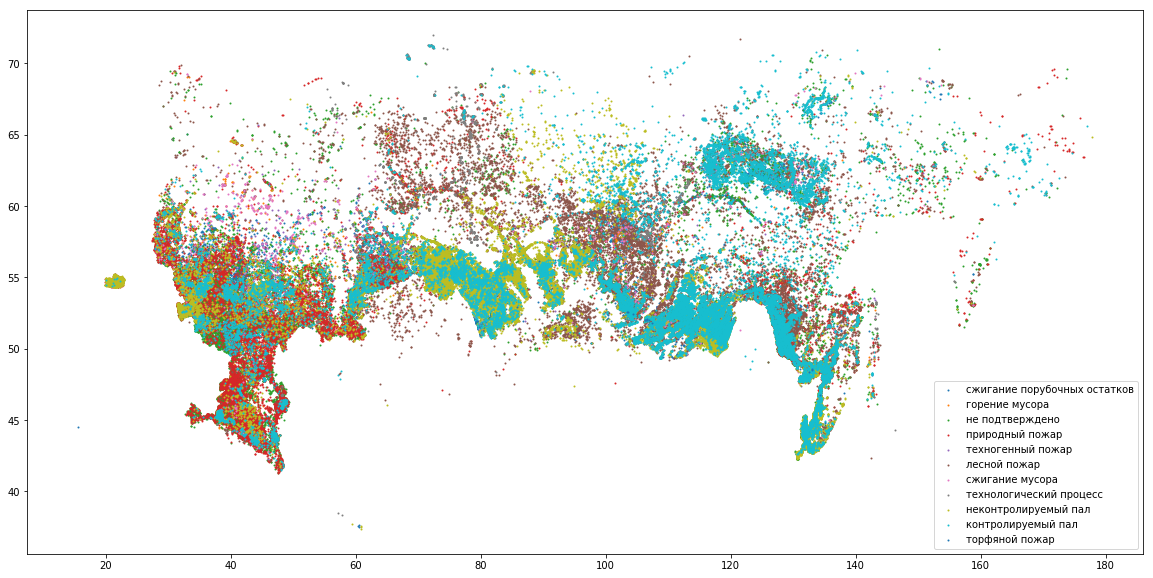

In [8]:
plt.figure(figsize = (20, 10))

for fire_type in fire_types.keys():
    data_type = data[data['fire_type'] == fire_type]
    plt.scatter(
        data_type['longitude'],
        data_type['latitude'],
        label = fire_types[fire_type], 
        s = 1
    ) 
plt.legend()
plt.show()

Как видно на полученном графике, разные типы пожаров по-разному распределены географически. Поэтому возьмем географические координаты тоже как фичи для модели и добавим еще "сдвиг" относительно средних (хотя это скорее важнее не для catboost, а для других моделей):
- `latitude_mean`, `longitude_mean`

In [9]:
data['latitude_mean'] = data['latitude'] - data['latitude'].mean()
data['longitude_mean'] = data['longitude'] - data['longitude'].mean()

In [10]:
data.head()

,fire_id,date,latitude,longitude,fire_type,fire_type_name,datetime,year,month,day,day_from_start,day_of_year,day_of_year_cos,day_of_year_sin,latitude_mean,longitude_mean
0,0,2012-01-01,42.913439,133.887370,4,сжигание порубочных остатков,2012-01-01,2012,1,1,0,0,1.000000,0.000000,-9.774891,46.739917
1,1,2012-01-01,43.378618,131.772265,3,горение мусора,2012-01-01,2012,1,1,0,0,1.000000,0.000000,-9.309712,44.624811
2,2,2012-01-01,42.634134,130.479116,4,сжигание порубочных остатков,2012-01-01,2012,1,1,0,0,1.000000,0.000000,-10.054196,43.331662
3,3,2012-01-02,43.108370,132.001058,11,не подтверждено,2012-01-02,2012,1,2,1,1,0.999852,0.017213,-9.579960,44.853605
4,4,2012-01-02,42.890825,131.337416,4,сжигание порубочных остатков,2012-01-02,2012,1,2,1,1,0.999852,0.017213,-9.797506,44.189962


Так как я планирую использовать в модели много фичей, связанных со временем, я разделю данные на train и test тоже по времени

In [11]:
train = data[data['year'] <= 2017]
test = data[data['year'] > 2017]

features = ['latitude', 'longitude', 'year', 'month', 'day', 'day_from_start', 'day_of_year', 'day_of_year_cos', 
            'day_of_year_sin', 'latitude_mean', 'longitude_mean']
X_train = train[features]
X_test = test[features]
y_train = train['fire_type']
y_test = test['fire_type']

Будем рассматривать `year`, `month` как категориальные фичи.

In [12]:
def create_features_data(df):
    for feature in cat_feature_names:
        df[feature] = df[feature].apply(str)

    return FeaturesData(
        df[num_feature_names].as_matrix().astype(np.float32),
        df[cat_feature_names].as_matrix(),
        num_feature_names,
        cat_feature_names
    )

num_feature_names = ['latitude', 'longitude', 'day', 'day_from_start', 'day_of_year', 'day_of_year_cos', 'day_of_year_sin', 
                     'latitude_mean', 'longitude_mean']
cat_feature_names = ['year', 'month']

fd_train = create_features_data(X_train)
fd_test = create_features_data(X_test)

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


Затем обучим и применим CatBoostClassifier с подобранными параметрами

In [13]:
cbc = CatBoostClassifier(
    n_estimators = 500,
    max_depth = 7,
    loss_function = 'MultiClass',
    verbose = False
)

cbc.fit(fd_train, y_train)
y_pred_proba_train = cbc.predict_proba(fd_train)
y_pred_proba_test = cbc.predict_proba(fd_test)

In [14]:
print(y_pred_proba_train[0])
print(y_pred_proba_test[0])

[0.00822061 0.01854665 0.042541   0.12618646 0.04879354 0.17977611
 0.00146181 0.01682504 0.05043627 0.03495509 0.47225742]
[0.02944548 0.01721379 0.4124685  0.32928495 0.09155778 0.02524334
 0.00061562 0.00559443 0.01263339 0.03230183 0.0436409 ]


Чтобы оценить полученный результат, нужно вычислить *Micro-averaged Multi-Class ROC-AUC*

Т.к. `sklearn.metrics.roc_auc_score` не работает для оценки singlelabel multiclass classification (как данная задача), преобразуем y_train, y_test в формат, соответствующий задаче multilabel multiclass classification

In [15]:
from sklearn.preprocessing import OneHotEncoder

def to_multilabel(val):
    encoder = OneHotEncoder()
    return encoder.fit_transform(pd.DataFrame({'y': val})).todense()

y_train_multilabel = to_multilabel(y_train)
y_test_multilabel = to_multilabel(y_test)

C:\Users\Nikita\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Nikita\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you 

In [16]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_multilabel, y_pred_proba_train, average = 'micro'))
print(roc_auc_score(y_test_multilabel, y_pred_proba_test, average = 'micro'))

0.9476699264180737
0.9115533597971212


Полученный скор подтверждается проверкой модели на https://wildfire.sberbank.ai

Теперь обучим итоговую модель на всех данных

In [17]:
X = data[features]
fd = create_features_data(X)
y = data['fire_type']

cbc.fit(fd, y)
with open('solution/model.pickle', 'wb') as fout:
    pickle.dump(cbc, fout, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


И посмотрим, насколько сильно влияние каждой из фич на получаемые предсказания

In [18]:
pd.DataFrame(zip(cbc.feature_names_, cbc.feature_importances_)).sort_values(by = 1, ascending = False)

,0,1
1,longitude,17.048301
8,longitude_mean,16.609454
0,latitude,11.811189
7,latitude_mean,10.906068
5,day_of_year_cos,10.095867
9,year,9.896136
10,month,8.486048
3,day_from_start,6.982787
6,day_of_year_sin,4.594788
4,day_of_year,2.904310
